# CS486 - Artificial Intelligence
## Lesson 28 - Decision Networks

An agent is said to be *rational* if and only if it chooses the action that yields the highest expected utility, averaged over all the possible outcomes of the action. A major element in the design of rational agents is the mechanism for making decisions about which actions to adopt in order to achieve their goals. Today we'll discuss how an agent leverages information gathering to best support decision making. 

In [7]:
import helpers
from aima.probability import *
from aima.notebook import psource

### Decision Networks

For an agent in an environment, a decision network represents information about the agent's current state, its possible actions, the state that will result from the agent's action, and the utility of that state. Decision networks have three primary kinds of nodes which are:

1. **Chance nodes**: These represent random variables, just like in Bayesian networks.
2. **Decision nodes**: These represent points where the decision-makes has a choice between different actions and the decision maker tries to find the optimal decision at these nodes with regard to the cost, safety and resulting utility.
3. **Utility nodes**: The arcs into a utility node represent the information that an agent uses to compute utility. 

To evaluate a decision network, we do the following:

1. Initialize the evidence variables according to the current state.
2. Calculate posterior probabilities for each possible value of the decision node and calculate the utility resulting from that action.
3. Return the action with the highest utility.

Let's have a look at the implementation of the `DecisionNetwork` class.

In [8]:
psource(DecisionNetwork)

Having **perfect information** refers to a state of being fully aware of the current state, the cost functions, and the outcomes of actions. If an agent has perfect information about the environment, maximum expected utility calculations are exact and can be computed with absolute certainty. 

The **value of perfect information (VPI)** is the price that an agent would be willing to pay in order to gain access to perfect information. VPI is **non-negative**, **non-additive** and **order-independent**.

For a random variable $E'$ whose value is currently unknown, the value of discovering $E'$, given current information $e$ must average over all possible values $e'$ that we might discover for $E'$, using our *current* beliefs about its value.
The VPI of $E'$ is then given by:

$$VPI(E'\mid{e}) = \left(\sum_{e'}P(e'\mid{e}) MEU(e,e')\right) - MEU(e)$$



An information gathering agent works by repeatedly selecting the observations with the highest information value, until the cost of the next observation is greater than its expected benefit.

### Partially Observable Markov Decision Problems

A POMDP is thus a sequential decision problem for for a *partially* observable, stochastic environment with a Markovian transition model, an emission model for inferring state from observation, and additive rewards. 

Practically, a POMDP has the following, which an MDP also has:
- A set of states, each denoted by $s$
- A set of actions available in each state, $A(s)$
- A reward accrued on attaining some state, $R(s)$
- A transition probability $P(s'\ |\ s, a)$ of action $a$ changing the state from $s$ to $s'$

And the following, which an MDP does not:
- A sensor model $P(e\ |\ s)$ on evidence conditional on states

Additionally, the POMDP is now uncertain of its current state hence has:
- A belief vector $b$ representing the certainty of being in each state (as a probability distribution)

#### New uncertainties

It is useful to intuitively appreciate the new uncertainties that have arisen in the agent's awareness of its own state.

- At any point, the agent has belief vector $b$, the distribution of its believed likelihood of being in each state $s$.
- For each of these states $s$ that the agent may **actually** be in, it has some set of actions given by $A(s)$.
- Each of these actions may transport it to some other state $s'$, assuming an initial state $s$, with probability $P(s'\ |\ s, a)$
- Once the action is performed, the agent receives a percept $e$. $P(e\ |\ s)$ now tells it the chances of having perceived $e$ for each state $s$. The agent must use this information to update its new belief state appropriately.

#### Evolution of the belief vector - the `FORWARD` function

The new belief vector $b'(s')$ after an action $a$ on the belief vector $b(s)$ and the noting of evidence $e$ is:
$$ b'(s') = \alpha P(e\ |\ s') \sum_s P(s'\ | s, a) b(s)$$ 

where $\alpha$ is a normalising constant (to retain the interpretation of $b$ as a probability distribution.

This equation is just counts the sum of likelihoods of going to a state $s'$ from every possible state $s$, times the initial likelihood of being in each $s$. This is multiplied by the likelihood that the known evidence actually implies the new state $s'$. 

This function is represented as `b' = FORWARD(b, a, e)`

#### Probability distribution of the evolving belief vector

The goal here is to find $P(b'\ |\ b, a)$ - the probability that action $a$ transforms belief vector $b$ into belief vector $b'$. The following steps illustrate this -

The probability of observing evidence $e$ when action $a$ is enacted on belief vector $b$ can be distributed over each possible new state $s'$ resulting from it:
\begin{align*}
    P(e\ |\ b, a) &= \sum_{s'} P(e\ |\ b, a, s') P(s'\ |\ b, a) \\
                  &= \sum_{s'} P(e\ |\ s') P(s'\ |\ b, a) \\
                  &= \sum_{s'} P(e\ |\ s') \sum_s P(s'\ |\ s, a) b(s)
\end{align*}

The probability of getting belief vector $b'$ from $b$ by application of action $a$ can thus be summed over all possible evidences $e$:
\begin{align*}
    P(b'\ |\ b, a) &= \sum_{e} P(b'\ |\ b, a, e) P(e\ |\ b, a) \\
                  &= \sum_{e} P(b'\ |\ b, a, e) \sum_{s'} P(e\ |\ s') \sum_s P(s'\ |\ s, a) b(s)
\end{align*}

where $P(b'\ |\ b, a, e) = 1$ if $b' = $ `FORWARD(b, a, e)` and $= 0$ otherwise.

Given initial and final belief states $b$ and $b'$, the transition probabilities still depend on the action $a$ and observed evidence $e$. Some belief states may be achievable by certain actions, but have non-zero probabilities for states prohibited by the evidence $e$. Thus, the above condition thus ensures that only valid combinations of $(b', b, a, e)$ are considered.

#### A modified rewardspace

For MDPs, the reward space was simple - one reward per available state. However, for a belief vector $b(s)$, the expected reward is now:
$$\rho(b) = \sum_s b(s) R(s)$$

Thus, as the belief vector can take infinite values of the distribution over states, so can the reward for each belief vector vary over a hyperplane in the belief space, or space of states (planes in an $N$-dimensional space are formed by a linear combination of the axes).

In [9]:
from aima.mdp import * 
psource(POMDP)

The `POMDP` class includes all variables of the `MDP` class and additionally also stores the sensor model in `e_prob`.
<br>
<br>
`remove_dominated_plans`, `remove_dominated_plans_fast`, `generate_mapping` and `max_difference` are helper methods for `pomdp_value_iteration` which will be explained shortly.

To understand how we can model a partially observable MDP, let's take a simple example.
Let's consider a simple two state world.
The states are labelled 0 and 1, with the reward at state 0 being 0 and at state 1 being 1.
<br>
There are two actions:
<br>
`Stay`: stays put with probability 0.9 and
`Go`: switches to the other state with probability 0.9.
<br>
For now, let's assume the discount factor `gamma` to be 1.
<br>
The sensor reports the correct state with probability 0.6.
<br>
This is a simple problem with a trivial solution.
Obviously the agent should `Stay` when it thinks it is in state 1 and `Go` when it thinks it is in state 0.
<br>
The belief space can be viewed as one-dimensional because the two probabilities must sum to 1.

Let's model this POMDP using the `POMDP` class.

In [10]:
# transition probability P(s'|s,a)
t_prob = [[[0.9, 0.1], [0.1, 0.9]], [[0.1, 0.9], [0.9, 0.1]]]
# evidence function P(e|s)
e_prob = [[[0.6, 0.4], [0.4, 0.6]], [[0.6, 0.4], [0.4, 0.6]]]
# reward function
rewards = [[0.0, 0.0], [1.0, 1.0]]
# discount factor
gamma = 0.95
# actions
actions = ('0', '1')
# states
states = ('0', '1')

In [11]:
pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)

## POMDP VALUE ITERATION
Defining a POMDP is useless unless we can find a way to solve it. As POMDPs can have infinitely many belief states, we cannot calculate one utility value for each state as we did in `value_iteration` for MDPs.
<br>
Instead of thinking about policies, we should think about conditional plans and how the expected utility of executing a fixed conditional plan varies with the initial belief state.
<br>
If we bound the depth of the conditional plans, then there are only finitely many such plans and the continuous space of belief states will generally be divided inte _regions_, each corresponding to a particular conditional plan that is optimal in that region. The utility function, being the maximum of a collection of hyperplanes, will be piecewise linear and convex.
<br>
For the one-step plans `Stay` and `Go`, the utility values are as follows
<br>
<br>
$$\alpha_{|Stay|}(0) = R(0) + \gamma(0.9R(0) + 0.1R(1)) = 0.1$$
$$\alpha_{|Stay|}(1) = R(1) + \gamma(0.9R(1) + 0.1R(0)) = 1.9$$
$$\alpha_{|Go|}(0) = R(0) + \gamma(0.9R(1) + 0.1R(0)) = 0.9$$
$$\alpha_{|Go|}(1) = R(1) + \gamma(0.9R(0) + 0.1R(1)) = 1.1$$

The utility function can be found by `pomdp_value_iteration`.
<br>
To summarize, it generates a set of all plans consisting of an action and, for each possible next percept, a plan in U with computed utility vectors.
The dominated plans are then removed from this set and the process is repeated till the maximum difference between the utility functions of two consecutive iterations reaches a value less than a threshold value.

In [13]:
#pseudocode('POMDP-Value-Iteration')

Let's have a look at the `pomdp_value_iteration` function.

In [14]:
psource(pomdp_value_iteration)

This function uses two aptly named helper methods from the `POMDP` class, `remove_dominated_plans` and `max_difference`.

Let's consider a problem where we have two doors, one to our left and one to our right.
One of these doors opens to a room with a tiger in it, and the other one opens to an empty hall.
<br>
We will call our two states `0` and `1` for `left` and `right` respectively.
<br>
The possible actions we can take are as follows:
<br>
1. __Open-left__: Open the left door.
Represented by `0`.
2. __Open-right__: Open the right door.
Represented by `1`.
3. __Listen__: Listen carefully to one side and possibly hear the tiger breathing.
Represented by `2`.

<br>
The possible observations we can get are as follows:
<br>
1. __TL__: Tiger seems to be at the left door.
2. __TR__: Tiger seems to be at the right door.

<br>
The reward function is as follows:
<br>
We get +10 reward for opening the door to the empty hall and we get -100 reward for opening the other door and setting the tiger free.
<br>
Listening costs us -1 reward.
<br>
We want to minimize our chances of setting the tiger free.


Our transition probabilities can be defined as:
<br>
<br>
Action `0` (Open left door)
$$
    P(0) = 
    \left[ {\begin{array}{cc}
    0.5 & 0.5 \\
    0.5 & 0.5 \\
    \end{array}}\right] \\
$$
    
Action `1` (Open right door)
$$
    P(1) = 
    \left[ {\begin{array}{cc}
    0.5 & 0.5 \\
    0.5 & 0.5 \\
    \end{array}}\right] \\
$$
    
Action `2` (Listen)
$\\
    P(2) = 
    \left[ {\begin{array}{cc}
    1.0 & 0.0 \\
    0.0 & 1.0 \\
    \end{array}}\right] \\
    \\
    $
    
<br>
<br>
Our observation probabilities can be defined as:
<br>
<br>
$\\
    O(0) = 
    \left[ {\begin{array}{ccc}
    Open left & TL & TR \\
    Tiger: left & 0.5 & 0.5 \\
    Tiger: right & 0.5 & 0.5 \\
    \end{array}}\right] \\
    \\
    $

$\\
    O(1) = 
    \left[ {\begin{array}{ccc}
    Open right & TL & TR \\
    Tiger: left & 0.5 & 0.5 \\
    Tiger: right & 0.5 & 0.5 \\
    \end{array}}\right] \\
    \\
    $

$\\
    O(2) = 
    \left[ {\begin{array}{ccc}
    Listen & TL & TR \\
    Tiger: left & 0.85 & 0.15 \\
    Tiger: right & 0.15 & 0.85 \\
    \end{array}}\right] \\
    \\
    $

<br>
<br>
The rewards of this POMDP are defined as:
<br>
<br>
$\\
    R(0) = 
    \left[ {\begin{array}{cc}
    Openleft & Reward \\
    Tiger: left & -100 \\
    Tiger: right & +10 \\
    \end{array}}\right] \\
    \\
    $
    
$\\
    R(1) = 
    \left[ {\begin{array}{cc}
    Openright & Reward \\
    Tiger: left & +10 \\
    Tiger: right & -100 \\
    \end{array}}\right] \\
    \\
    $
    
$\\
    R(2) = 
    \left[ {\begin{array}{cc}
    Listen & Reward \\
    Tiger: left & -1 \\
    Tiger: right & -1 \\
    \end{array}}\right] \\
    \\
    $
    
<br>
Based on these matrices, we will initialize our variables.

Let's first define our transition state.

In [15]:
t_prob = [[[0.5, 0.5], 
           [0.5, 0.5]], 
          
          [[0.5, 0.5], 
           [0.5, 0.5]], 
          
          [[1.0, 0.0], 
           [0.0, 1.0]]]

Followed by the observation model.

In [16]:
e_prob = [[[0.5, 0.5], 
           [0.5, 0.5]], 
          
          [[0.5, 0.5], 
           [0.5, 0.5]], 
          
          [[0.85, 0.15], 
           [0.15, 0.85]]]

And the reward model.

In [17]:
rewards = [[-100, 10], 
           [10, -100], 
           [-1, -1]]

Let's now define our states, observations and actions.
<br>
We will use `gamma` = 0.95 for this example.
<br>

In [18]:
# 0: open-left, 1: open-right, 2: listen
actions = ('0', '1', '2')
# 0: left, 1: right
states = ('0', '1')

gamma = 0.95

We have all the required variables to instantiate an object of the `POMDP` class.

In [19]:
pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)

We can now find the utility function by running `pomdp_value_iteration` on our `pomdp` object.

In [20]:
utility = pomdp_value_iteration(pomdp, epsilon=3)
utility

defaultdict(list,
            {'1': [array([ 26.94830804, -83.05169196])],
             '2': [array([23.55049363, -0.76359097]),
              array([23.55049363, -0.76359097]),
              array([23.55049363, -0.76359097]),
              array([23.55049363, -0.76359097]),
              array([23.24120177,  1.56028929]),
              array([23.24120177,  1.56028929]),
              array([23.24120177,  1.56028929]),
              array([20.0874279 , 15.03900771]),
              array([20.0874279 , 15.03900771]),
              array([20.0874279 , 15.03900771]),
              array([20.0874279 , 15.03900771]),
              array([17.91696135, 17.91696135]),
              array([17.91696135, 17.91696135]),
              array([17.91696135, 17.91696135]),
              array([17.91696135, 17.91696135]),
              array([17.91696135, 17.91696135]),
              array([15.03900771, 20.0874279 ]),
              array([15.03900771, 20.0874279 ]),
              array([15.03900771, 20.0

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_utility(utility):
    open_left = utility['0'][0]
    open_right = utility['1'][0]
    listen_left = utility['2'][0]
    listen_right = utility['2'][-1]
    left = (open_left[0] - listen_left[0]) / (open_left[0] - listen_left[0] + listen_left[1] - open_left[1])
    right = (open_right[0] - listen_right[0]) / (open_right[0] - listen_right[0] + listen_right[1] - open_right[1])
    
    colors = ['g', 'b', 'k']
    for action in utility:
        for value in utility[action]:
            plt.plot(value, color=colors[int(action)])
    plt.vlines([left, right], -10, 35, linestyles='dashed', colors='c')
    plt.ylim(-10, 35)
    plt.xlim(0, 1)
    plt.text(left/2 - 0.35, 30, 'open-left')
    plt.text((right + left)/2 - 0.04, 30, 'listen')
    plt.text((right + 1)/2 + 0.22, 30, 'open-right')
    plt.show()

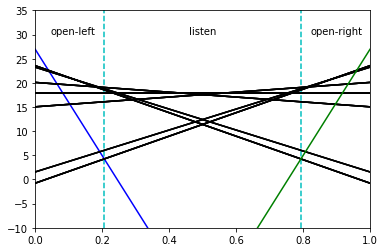

In [23]:
plot_utility(utility)

### POMDPs - a rigorous outline

A POMDP is thus a sequential decision problem for for a *partially* observable, stochastic environment with a Markovian transition model, a known 'sensor model' for inferring state from observation, and additive rewards. 

Practically, a POMDP has the following, which an MDP also has:
- a set of states, each denoted by $s$
- a set of actions available in each state, $A(s)$
- a reward accrued on attaining some state, $R(s)$
- a transition probability $P(s'\ |\ s, a)$ of action $a$ changing the state from $s$ to $s'$

And the following, which an MDP does not:
- a sensor model $P(e\ |\ s)$ on evidence conditional on states

Additionally, the POMDP is now uncertain of its current state hence has:
- a belief vector $b$ representing the certainty of being in each state (as a probability distribution)


#### New uncertainties

It is useful to intuitively appreciate the new uncertainties that have arisen in the agent's awareness of its own state.

- At any point, the agent has belief vector $b$, the distribution of its believed likelihood of being in each state $s$.
- For each of these states $s$ that the agent may **actually** be in, it has some set of actions given by $A(s)$.
- Each of these actions may transport it to some other state $s'$, assuming an initial state $s$, with probability $P(s'\ |\ s, a)$
- Once the action is performed, the agent receives a percept $e$. $P(e\ |\ s)$ now tells it the chances of having perceived $e$ for each state $s$. The agent must use this information to update its new belief state appropriately.

#### Evolution of the belief vector - the `FORWARD` function

The new belief vector $b'(s')$ after an action $a$ on the belief vector $b(s)$ and the noting of evidence $e$ is:
$$ b'(s') = \alpha P(e\ |\ s') \sum_s P(s'\ | s, a) b(s)$$ 

where $\alpha$ is a normalising constant (to retain the interpretation of $b$ as a probability distribution.

This equation is just counts the sum of likelihoods of going to a state $s'$ from every possible state $s$, times the initial likelihood of being in each $s$. This is multiplied by the likelihood that the known evidence actually implies the new state $s'$. 

This function is represented as `b' = FORWARD(b, a, e)`

#### Probability distribution of the evolving belief vector

The goal here is to find $P(b'\ |\ b, a)$ - the probability that action $a$ transforms belief vector $b$ into belief vector $b'$. The following steps illustrate this -

The probability of observing evidence $e$ when action $a$ is enacted on belief vector $b$ can be distributed over each possible new state $s'$ resulting from it:
\begin{align*}
    P(e\ |\ b, a) &= \sum_{s'} P(e\ |\ b, a, s') P(s'\ |\ b, a) \\
                  &= \sum_{s'} P(e\ |\ s') P(s'\ |\ b, a) \\
                  &= \sum_{s'} P(e\ |\ s') \sum_s P(s'\ |\ s, a) b(s)
\end{align*}

The probability of getting belief vector $b'$ from $b$ by application of action $a$ can thus be summed over all possible evidences $e$:
\begin{align*}
    P(b'\ |\ b, a) &= \sum_{e} P(b'\ |\ b, a, e) P(e\ |\ b, a) \\
                  &= \sum_{e} P(b'\ |\ b, a, e) \sum_{s'} P(e\ |\ s') \sum_s P(s'\ |\ s, a) b(s)
\end{align*}

where $P(b'\ |\ b, a, e) = 1$ if $b' = $ `FORWARD(b, a, e)` and $= 0$ otherwise.

Given initial and final belief states $b$ and $b'$, the transition probabilities still depend on the action $a$ and observed evidence $e$. Some belief states may be achievable by certain actions, but have non-zero probabilities for states prohibited by the evidence $e$. Thus, the above condition thus ensures that only valid combinations of $(b', b, a, e)$ are considered.

#### A modified rewardspace

For MDPs, the reward space was simple - one reward per available state. However, for a belief vector $b(s)$, the expected reward is now:
$$\rho(b) = \sum_s b(s) R(s)$$

Thus, as the belief vector can take infinite values of the distribution over states, so can the reward for each belief vector vary over a hyperplane in the belief space, or space of states (planes in an $N$-dimensional space are formed by a linear combination of the axes).

To understand how we can model a partially observable MDP, let's work through a simple two state world example. The states are labeled 0 and 1, with the reward at state 0 being 0 and at state 1 being 1.

There are two actions:

* `Stay`: stays put with probability 0.9 and
* `Go`: switches to the other state with probability 0.9.

For now, let's assume the discount factor `gamma` to be 1. The sensor reports the correct state with probability 0.6. The agent should `Stay` when it thinks it is in state 1 and `Go` when it thinks it is in state 0. The belief space can be viewed as one-dimensional because the two probabilities must sum to 1.

Let's model this POMDP using the `POMDP` class.

In [34]:
# transition probability P(s'|s,a)
t_prob = [[[0.9, 0.1], [0.1, 0.9]], [[0.1, 0.9], [0.9, 0.1]]]
# evidence function P(e|s)
e_prob = [[[0.6, 0.4], [0.4, 0.6]], [[0.6, 0.4], [0.4, 0.6]]]
# reward function
rewards = [[0.0, 0.0], [1.0, 1.0]]
# discount factor
gamma = 0.95
# actions
actions = ('0', '1')
# states
states = ('0', '1')

In [35]:
pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)

## POMDP VALUE ITERATION

As POMDPs can have infinitely many belief states, we cannot calculate one utility value for each state as we did in `value_iteration` for MDPs.

Instead of thinking about policies, we should think about conditional plans and how the expected utility of executing a fixed conditional plan varies with the initial belief state.

If we bound the depth of the conditional plans, then there are only finitely many such plans and the continuous space of belief states will generally be divided inte _regions_, each corresponding to a particular conditional plan that is optimal in that region. The utility function, being the maximum of a collection of hyperplanes, will be piecewise linear and convex.

For the one-step plans `Stay` and `Go`, the utility values are as follows

$$\alpha_{|Stay|}(0) = R(0) + \gamma(0.9R(0) + 0.1R(1)) = 0.1$$
$$\alpha_{|Stay|}(1) = R(1) + \gamma(0.9R(1) + 0.1R(0)) = 1.9$$
$$\alpha_{|Go|}(0) = R(0) + \gamma(0.9R(1) + 0.1R(0)) = 0.9$$
$$\alpha_{|Go|}(1) = R(1) + \gamma(0.9R(0) + 0.1R(1)) = 1.1$$

The utility function can be found by `pomdp_value_iteration`.
<br>
To summarize, it generates a set of all plans consisting of an action and, for each possible next percept, a plan in U with computed utility vectors.
The dominated plans are then removed from this set and the process is repeated till the maximum difference between the utility functions of two consecutive iterations reaches a value less than a threshold value.

In [37]:
psource(pomdp_value_iteration)

This function uses two aptly named helper methods from the `POMDP` class, `remove_dominated_plans` and `max_difference`.

Let's try solving a simple one-dimensional POMDP using value-iteration. Consider the problem of a user listening to voicemails. At the end of each message, they can either _save_ or _delete_ a message. This forms the unobservable state _S = {save, delete}_.

It is the task of the POMDP solver to guess which goal the user has. The belief space has two elements, _b(s = save)_ and _b(s = delete)_. For example, for the belief state _b = (1, 0)_, the left end of the line segment indicates _b(s = save) = 1_ and _b(s = delete) = 0_. The intermediate points represent varying degrees of certainty in the user's goal.

The machine has three available actions: it can _ask_ what the user wishes to do in order to infer his or her current goal, or it can _doSave_ or _doDelete_ and move to the next message. If the user says _save_, then an error may occur with probability 0.2, whereas if the user says _delete_, an error may occur with a probability 0.3.

The machine receives a large positive reward (+5) for getting the user's goal correct, a very large negative reward (-20) for taking the action _doDelete_ when the user wanted _save_, and a smaller but still significant negative reward (-10) for taking the action _doSave_ when the user wanted _delete_. There is also a small negative reward for taking the _ask_ action (-1). 

In [38]:
gamma = 0.95

# transition function P(s'|s,a)
t_prob = [
    # doSave from save, delete
    [[0.65, 0.35], [0.65, 0.35]],
    # doDelete from save, delete
    [[0.65, 0.35], [0.65, 0.35]],
    # ask from save, delete
    [[1.0, 0.0],   [0.0, 1.0]]
]

# evidence function P(e|s)
e_prob = [
    # doSave for save, delete    
    [[0.5, 0.5], [0.5, 0.5]], 
    [[0.5, 0.5], [0.5, 0.5]], 
    [[0.8, 0.2], [0.3, 0.7]]
]

rewards = [
    # doSave for save, delete
    [5, -10], 
    # doDelete for save, delete
    [-20, 5], 
    # ask for save, delete
    [-1, -1]
]

# doSave, doDelete, ask
actions = ('0', '1', '2')

# save, delete
states = ('0', '1')

pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)

We have defined the `POMDP` object.
Let's run `pomdp_value_iteration` to find the utility function.

In [39]:
utility = pomdp_value_iteration(pomdp, epsilon=0.1)
utility

defaultdict(list,
            {'0': [array([10.25103494, -4.74896506])],
             '2': [array([ 8.84407416, -0.64882031]),
              array([ 8.83942888, -0.63611271]),
              array([ 8.83941328, -0.63607377]),
              array([ 8.82057361, -0.59250655]),
              array([ 8.82044942, -0.59223694]),
              array([ 8.74518769, -0.44094031]),
              array([ 8.74493533, -0.44047727]),
              array([8.44002186, 0.07775055]),
              array([8.43800975, 0.08096086]),
              array([7.21866057, 1.88221091]),
              array([7.21457713, 1.88771792]),
              array([7.21455024, 1.88775197]),
              array([7.19825015, 1.90686364]),
              array([7.19819544, 1.90692218]),
              array([7.13211221, 1.97242405]),
              array([7.13167644, 1.97282955]),
              array([6.86758806, 2.20036916]),
              array([6.86670294, 2.20106529]),
              array([5.79712565, 2.9802232 ]),
              a

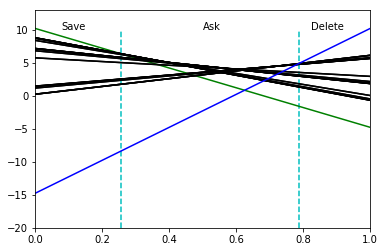

In [40]:
%matplotlib inline
plot_pomdp_utility(utility)